In [18]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gamma
from scipy.misc import factorial
from scipy.stats import norm
from matplotlib import animation, rc
from IPython.display import HTML
import base64
import cv2 as cv
from skimage.transform import resize
figSize = 5

# Population Receptive Field Estimation Technique Simulation

The aim of this computational neuroscience research project is to develope and simulate novel neuroimaging techniques for estimating PRF of human visual field using simulation.
The outline of the work can be summed up as such,

* Simulation Data
    * Creating bar stimulus 3D array
    * Retinotopic Mapping
    * Experiment Parmeters
    * Modelling BOLD Response
    * Downsampling to fMRI resolution
    
* Estimate the assumed PRF from simulated fMRI data
* Compare Assumed model with estimations
* Repeat with better stimulus protocol

# 1. Simulation Data
First we are going to generate the stimulus protocol.

## 1.1. Creating bar stimulus 3D array

In [19]:
radius = 10
precession = 0.1
barWidth = radius / 4
angles = [-90, 45, -180, 315, 90, 225, 0, 135]
nFrames = len(angles)*3



X = Y = np.arange(-radius, radius + precession, precession)
lenngth = len(X)
stim = np.zeros((nFrames, lenngth, lenngth))

f = 0
for angle in angles:
    for k in range(3):
        for i, x in enumerate(X):
            for j, y in enumerate(Y):
                if np.sin(np.deg2rad(angle))*x - np.cos(np.deg2rad(angle))*y <= (0.5-0.5*k)*radius + barWidth:
                    if np.sin(np.deg2rad(angle))*x - np.cos(np.deg2rad(angle))*y >= (0.5-0.5*k)*radius - barWidth:
                        stim[f, j, i] = 1
        # updates the frame
        f = f + 1
        

### Creating animation

In [20]:
fig = plt.figure(figsize=(figSize, figSize))
ax = plt.axes()  

# Animation function
def animate(i): 
    z = stim[i,:,:]
    cont = plt.contourf(X, Y, z)

    return cont  

anim = animation.FuncAnimation(fig, animate, frames=nFrames)

anim.save('stimulus.mp4', writer = 'ffmpeg', fps=1, codec='libx264')

with open('stimulus.mp4', 'rb') as f:
    video_tag = '<video controls alt="test" src="data:video/x-m4v;base64,{0}">'.format(base64.b64encode(f.read()).decode('utf-8'))
    
plt.close()   

### Description and comparison
Drifting bar apertures at various orientations used in Dumoulin(2007) paper; The bar width subtended 1/4th of the stimulus radius. Four bar orientations and two different motion directions for each bar were used, giving a total of 8 different bar with 3 diffrent location which gives 24 configurations within a given scan as shown bellow.
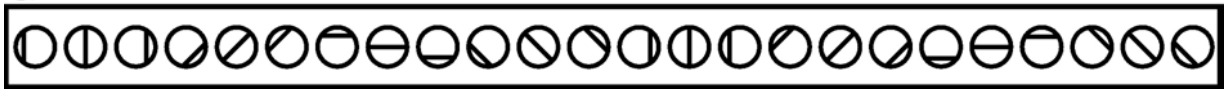

In [21]:
HTML(video_tag)

### Plot of overall visual field covered

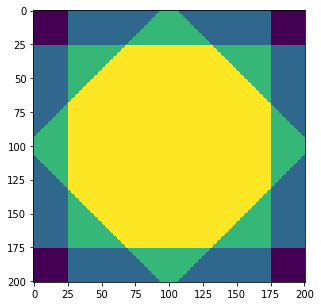

In [22]:
fig = plt.figure(figsize=(figSize, figSize))
shape2D = (len(X), len(Y))
proj2D = np.zeros(shape2D)
for i in range(nFrames):
    proj2D = proj2D + (stim[i, :, :]).reshape(shape2D)
    
plt.imshow(proj2D)

## 1.2. Retinotopic Mapping
The retinotopic mapping can be moddeled using the log-polar transformation $dst( \rho , \phi ) = src(x, y)$ which emulates the human “foveal” vision where,

$$
\begin{array}{l}
\rho = M \cdot \ln{\sqrt{x^2 + y^2}}\\
\phi = \arctan{\frac{y}{x}}  \\
\end{array}
$$

M – Magnitude scale parameter. It determines the radius of the bounding circle to transform too.

### Demonstration
We can do a forward and backward transformation on a sample image to show the cortical zooming effect which is emulates the behaviour of fovea.

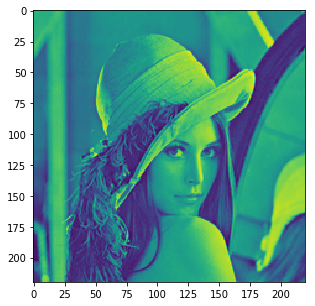

In [23]:
fig = plt.figure(figsize=(figSize, figSize))
img_test = cv.imread('lenna.png', 0)
plt.imshow(img_test)

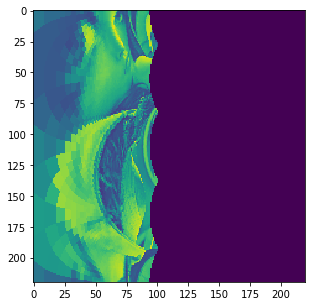

In [24]:
M = 20
fig = plt.figure(figsize=(figSize, figSize))
center = (img_test.shape[0]/2, img_test.shape[1]/2)

warped_img = cv.logPolar(img_test, center, M, cv.WARP_FILL_OUTLIERS)
back_img = cv.logPolar(warped_img, center, M, cv.WARP_INVERSE_MAP + cv.WARP_FILL_OUTLIERS)

plt.imshow(warped_img)

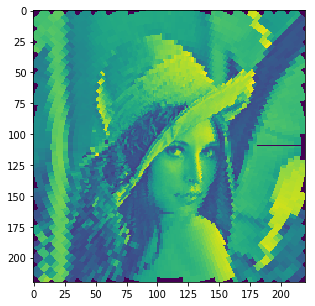

In [25]:
fig = plt.figure(figsize=(figSize, figSize))
plt.imshow(back_img)

### Stimulus Mapping

In [26]:
M = 40
center = (stim.shape[1]/2, stim.shape[2]/2)
logpolar_stim = np.zeros(stim.shape)
recovered_stim = np.zeros(stim.shape)

for frame in range(nFrames):
    img = stim[frame, :, :]
    logpolar_stim[frame, :, :] = cv.logPolar(img, center, M, cv.WARP_FILL_OUTLIERS)
    recovered_stim[frame, :, :] = cv.logPolar(logpolar_stim[frame, :, :], center, M, cv.WARP_INVERSE_MAP + cv.WARP_FILL_OUTLIERS)

### Plot of overall activated neuronal field

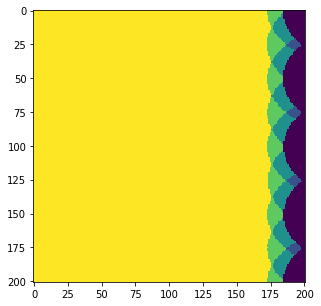

In [27]:
fig = plt.figure(figsize=(figSize, figSize))
shape2D = (stim.shape[1], stim.shape[1])
proj2D = np.zeros(shape2D)
for frame in range(nFrames):
    proj2D = proj2D + (logpolar_stim[frame, :, :]).reshape(shape2D)
    
plt.imshow(proj2D)

### Animation of activation of neuronal field

In [28]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes()  

# Animation function
def animate(i): 
    z = logpolar_stim[i,:,:]
    cont = plt.contourf(X, Y, z)
    return cont  

anim = animation.FuncAnimation(fig, animate, frames=nFrames)

anim.save('mappedStimulus.mp4', fps=1, codec='libx264')

with open('mappedStimulus.mp4', 'rb') as f:
    video_tag = '<video controls alt="test" src="data:video/x-m4v;base64,{0}">'.format(base64.b64encode(f.read()).decode('utf-8'))
    
plt.close()           

### Comparison with the stimulus frames
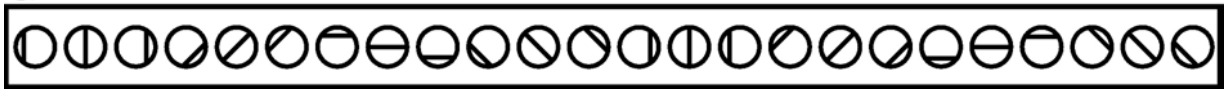

In [29]:
HTML(video_tag)

## 1.3. Neuronal Responses
First we need to assume the experiment parameters such as the TR and the event duration times. Then we can take the transformed stimulus frames as the boxcar neuronal responses.

In [30]:
TR = 3.0
TRs = 5 # number of TRs for each frame

neuronals = np.zeros((nFrames*TRs, len(X), len(Y)))
t = np.arange(0,nFrames*TRs*TR,TR)

# extending the stimlus time to allow TRs for each event to get neuronals activations
for frame in range(nFrames):
    for i in range(TRs):
        neuronals[frame*TRs + i, :, :] = logpolar_stim[frame, :, :]

## 1.4. Hemodynamic Responses
We can model the Hemodynamic response by assuming an LTI system and use the signle or double Gamma function as its impulse response. 
We can define the gamma distribution by providing its PDF: 
$$
f_X(x) = \frac{\lambda^{\alpha} x^{\alpha-1} e^{-\lambda x}}{\Gamma(\alpha)} \hspace {5pt} x > 0\\
\Gamma(\alpha) = \int_0^\infty x^{\alpha - 1} e^{-x} {\rm d}x, \hspace{20pt} \textrm{for }\alpha>0.
$$

Specifically, if $n \in \{1,2,3,...\}$, then
$$
\Gamma(n) = (n-1)!
$$


Therefore we can use a single shifted Gamma distribution with shape parameter n and rate $\lambda$ as the impulse reponse for the hemodynamic system,
$$
h(t) = \frac{\lambda^{n} (t-t_0)^{n-1} e^{-\lambda (t-t_0)}}{(n-1)!}
$$


In [31]:
def hrf_single_gamma(t,n,lmbd,t0):
    return gamma.pdf(t,n,loc=t0,scale=lmbd)


def hrf_double_gamma(t,n1,n2,lmbd1,lmbd2,t01,t02,a):
    c = (gamma.cdf(t[t.size-1],n1,loc=t01,scale=lmbd1) 
        - a * gamma.cdf(t[t.size-1],n2,loc=t02,scale=lmbd2))
            
    return ( 1/c * (gamma.pdf(t,n1,scale=lmbd1,loc=t01) 
                   - a * gamma.pdf(t,n2,scale=lmbd2,loc=t02)) )

In [32]:
# parameters for double gamma distribution function hrf:
n1 = 4
lmbd1 = 2.0
t01 = 0
n2 = 7
lmbd2 = 3
t02 = 0
a = 0.3
hrf = hrf_double_gamma(t, n1, n2, lmbd1, lmbd2, t01, t02, a)

responses = np.zeros((nFrames*TRs, lenngth, lenngth))
for i in range(len(X)):
    for j in range(len(Y)):
        n = neuronals[:, i, j]
        responses[:, i, j] = np.convolve(hrf, n)[0:len(t)]
        responses[:, i, j] = responses[:, i, j] + norm.rvs(scale=0.1, size=nFrames*TRs)

### Plots of HRF and example Neuronal and Hemodynamic responses

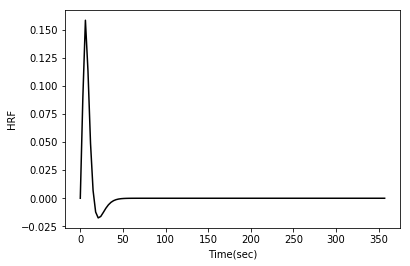

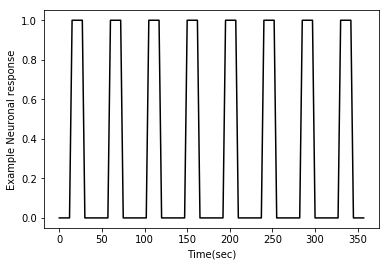

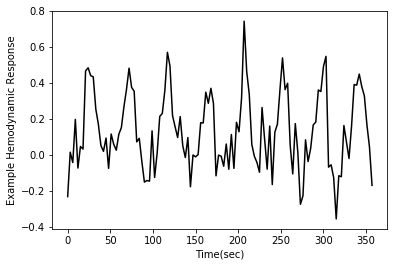

In [33]:
plt.plot(t, hrf, color = 'black')
plt.xlabel('Time(sec)')
plt.ylabel('HRF')
plt.show()



plt.plot(t, neuronals[:, 150, 50], color = 'black')
plt.xlabel('Time(sec)')
plt.ylabel('Example Neuronal response')
plt.show()


plt.plot(t, responses[:, 150, 50], color = 'black')
plt.xlabel('Time(sec)')
plt.ylabel('Example Hemodynamic Response')
plt.show()

## 1.5. Downsampling the Hemodynamic Responses
Here we downasmple the hemodynamic responses to get the fMRI rosultion.

Let's say on average, the surface area of V1 is about 3000 $mm^3$ and the fMRI voxel sizes are 3x3x3 mm. Therefore there should be about a 1000 voxels in the fMRI data that corresponds to t30he V1 area. So let's downsample the cortical map into 30X30.

In [34]:
nVoxels = 30
bolds = np.zeros((nFrames*TRs, nVoxels, nVoxels))
for frame in range(nFrames):
    img = responses[frame, :, :]
    img_resized = resize(img, (nVoxels, nVoxels), mode='constant', preserve_range=True)
    bolds[frame, :, :] = img_resized

# 2. PRF Estimation

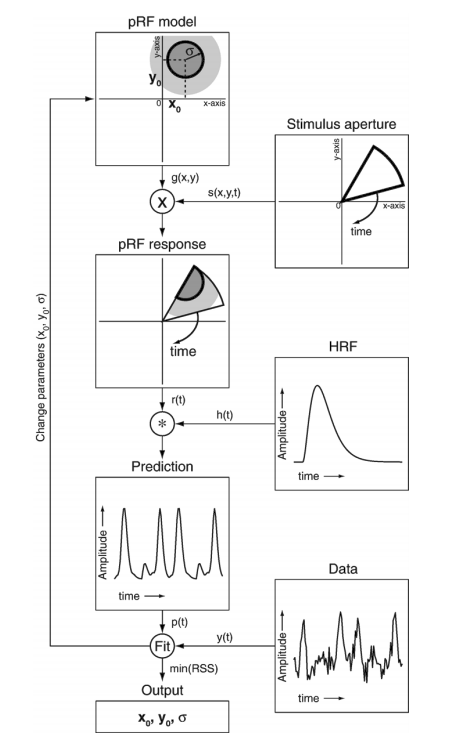